## 导入各类包

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import cm as cm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from factor_analyzer import factor_analyzer
from sklearn.metrics import mean_squared_error



## 定义异常类

In [22]:
class ana_err(Exception): pass

## data

In [23]:
data=pd.read_excel('D:\研究生\课程\编程基础\\NBA.xlsx')
data.head()

,球员姓名,位置,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,球员薪金
0,斯蒂芬-库里,得分后卫,1.91,86,29,7,79,33.38,31.933,4,是,高,高,3468
1,勒布朗-詹姆斯,大前锋,2.03,113,32,13,74,37.75,36.140,8,是,高,中,3329
2,保罗-米尔萨普,中锋,2.03,112,32,10,69,33.95,22.712,7,是,高,低,3127
3,戈登-海沃德,小前锋,2.03,103,27,6,73,34.45,25.382,5,是,高,中,2973
4,布雷克-格里芬,中锋,2.08,114,28,6,61,34.03,27.488,6,是,高,高,2951


In [24]:
lis=['大前锋','小前锋','得分后卫','控球后卫']
for name in lis:
    data[name]=data['位置'].apply(lambda x:1 if x==name else 0)
data.head()

,球员姓名,位置,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,球员薪金,大前锋,小前锋,得分后卫,控球后卫
0,斯蒂芬-库里,得分后卫,1.91,86,29,7,79,33.38,31.933,4,是,高,高,3468,0,0,1,0
1,勒布朗-詹姆斯,大前锋,2.03,113,32,13,74,37.75,36.140,8,是,高,中,3329,1,0,0,0
2,保罗-米尔萨普,中锋,2.03,112,32,10,69,33.95,22.712,7,是,高,低,3127,0,0,0,0
3,戈登-海沃德,小前锋,2.03,103,27,6,73,34.45,25.382,5,是,高,中,2973,0,1,0,0
4,布雷克-格里芬,中锋,2.08,114,28,6,61,34.03,27.488,6,是,高,高,2951,0,0,0,0


In [25]:
def change(x):
    if x=='高': return 3
    elif x=='中': return 2
    else: return 1
def be(x):
    if x=='是':return 1
    else:return 0
data['全明星']=data['全明星'].apply(be)
data['球队胜率']=data['球队胜率'].apply(change)
data['球队市值']=data['球队市值'].apply(change)
data=data.drop(['球员姓名','位置'],axis=1)
data.head()

,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,球员薪金,大前锋,小前锋,得分后卫,控球后卫
0,1.91,86,29,7,79,33.38,31.933,4,1,3,3,3468,0,0,1,0
1,2.03,113,32,13,74,37.75,36.140,8,1,3,2,3329,1,0,0,0
2,2.03,112,32,10,69,33.95,22.712,7,1,3,1,3127,0,0,0,0
3,2.03,103,27,6,73,34.45,25.382,5,1,3,2,2973,0,1,0,0
4,2.08,114,28,6,61,34.03,27.488,6,1,3,3,2951,0,0,0,0


## 数据分析类的定义

In [41]:
import matplotlib.pyplot as plt
class analysis:
    def __init__(self,X,y,k):
        if len(X)!=len(y):
            raise ana_err('the length of X and y is not same!')
        self.k=k
        if k==0:
            o=pd.DataFrame(np.ones([1,len(y)]),index=['const'])
            self.X=X.T.append(o).T
            self.y=y
            return 
        else:
            self.X=pd.DataFrame((X-X.mean())/X.std())
            self.y=pd.DataFrame((y-y.mean())/y.std())
        

    def overview(self):
        data=self.X.T.append(self.y.T).T
        n=len(data.columns)
        fig, ax = plt.subplots(ncols=n, nrows=n, figsize=(32, 32))
        name=data.columns.tolist()
        for i in range(n):
            for j in range(n):
                if i==j:
                    ax[i,j].hist(data.iloc[:,i],bins=20)
                else:
                    ax[i,j].scatter(data.iloc[:,i],data.iloc[:,j],s=0.1)
                if i==0:
                    ax[i,j].set_title(name[j],fontsize=10)
                if j==0:
                    ax[i,j].set_ylabel(name[i],fontsize=10)
        plt.show(self)
    
    def get_cor(self):
        data=self.X.T.append(self.y.T).T
        return data.corr()
    def plot_cor(self):
        a=self.get_cor()
        x=plt.figure(dpi=1000)
        p=plt.imshow(a)
        x.colorbar(p, ticks=[0.1*i for i in range(-10,10)])
        plt.show()

    def KMO(self):
        print('KMO值：',round(factor_analyzer.calculate_kmo(self.X)[1],5))
        print('巴特利特球：',round(factor_analyzer.calculate_bartlett_sphericity(self.X)[1],5))
              
    def anova(self):
        b=self.X.columns.tolist()
        a=self.y.columns.tolist()[0]
        formula = a+'~'+'+'.join(b)
        data=self.X.T.append(self.y.T).T
        anova_results = pd.DataFrame(anova_lm(ols(formula,data).fit()))
        anova_results.to_excel('D:\研究生\课程\编程基础\方差分析结果.xlsx')
        print(anova_results)
        
        
        
        
    def linear_beta(self):
            xtx=self.X.T.dot(self.X)
        try:
            inv=pd.DataFrame(np.linalg.pinv(xtx),xtx.columns, xtx.index)
        except:
            raise ana_err('XtX cannot be inversed')
        a=inv.dot(self.X.T)
        return a.dot(self.y)
    
    def ridge(self):
        if self.k==0:
            X=(self.X-self.X.mean())/self.X.std()
            y=(self.y-self.y.mean())/self.y.std()
        else:
            X=self.X
            y=self.y
        n=len(X.columns)
        xtx=self.X.T.dot(X)
        xtxk=xtx+np.diag([np.exp(k) for i in range(n)])
        try:
            inv=pd.DataFrame(np.linalg.pinv(xtxk),xtxk.columns, xtxk.index)
        except:
            raise ana_err('XtXk cannot be inversed')
        a=inv.dot(X.T).dot(y)
        return a

    def plot_ridge(self,start,end):
        l=np.linspace(start,end,100)
        re=self.ridge(l[0])
        for ll in l[1:]:
            re=re.merge(self.ridge(ll),left_index=True, right_index=True)
        p=plt.figure(figsize=(10,10))
        name=self.X.columns.tolist()
        for i in range(len(self.X.columns)):
            plt.plot(l,re.iloc[i,:],label=name[i])
        plt.legend(loc='upper right')
        plt.show()
    
    def PCA(self,n):
        xtx=self.X.T.dot(self.X)
        val,vec=np.linalg.eig(xtx)
        pd.DataFrame(vec).to_excel('D:\研究生\课程\编程基础\PCA.xlsx')
        if len(val)<=n:return self.linear_beta()
        rank=[]
        V=[]
        val=list(val)
        #print(val)
        for i in range(n):
            num=val.index(max(val))
            rank.append(val[num])
            val[num]=-1e10
            V.append(vec[:,num])
        V=np.array(V)
        #print(V.T)
        i_rank=[1/i for i in rank]
        d=np.diag(i_rank)
        rr=np.dot(d,V)
        return np.dot(V.T,np.dot(np.dot(rr,self.X.T),self.y))
    
    def plot_PCA(self):
        xtx=self.X.T.dot(self.X)
        val,vec=np.linalg.eig(xtx)
        val.sort()
        s=sum(val)
        vv=[v/s for v in val[::-1]]
        n=len(val)
        su=0
        print('累积贡献率为：')
        for i in range(n):
            su+=vv[i]
            print('前',i+1,'个变量的累积贡献率为：',su)
        fig=plt.figure()
        plt.plot(list(range(1,n+1)),vv)
        plt.xticks(np.linspace(1,n,n))
        
    def MSE(self,beta):
        y_h=np.array(self.X.dot(beta))
        e=np.array(self.y)-y_h
        #print('e',e)
        s=np.dot(e.T,e)
        return s/(len(self.y)-1-len(self.X.T))
    
    def R2(self,beta):
        y_h=np.array(self.X.dot(beta))
        e=np.array(self.y)-y_h
        s=np.dot(e.T,e)
        return 1-s/np.dot((self.y-self.y.mean()).T,self.y-self.y.mean())
        
        

## Overview

In [46]:
ana=analysis(data.drop(['球员薪金'],axis=1),data['球员薪金'],1)

E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 36523 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 39640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 20307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 40836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-package

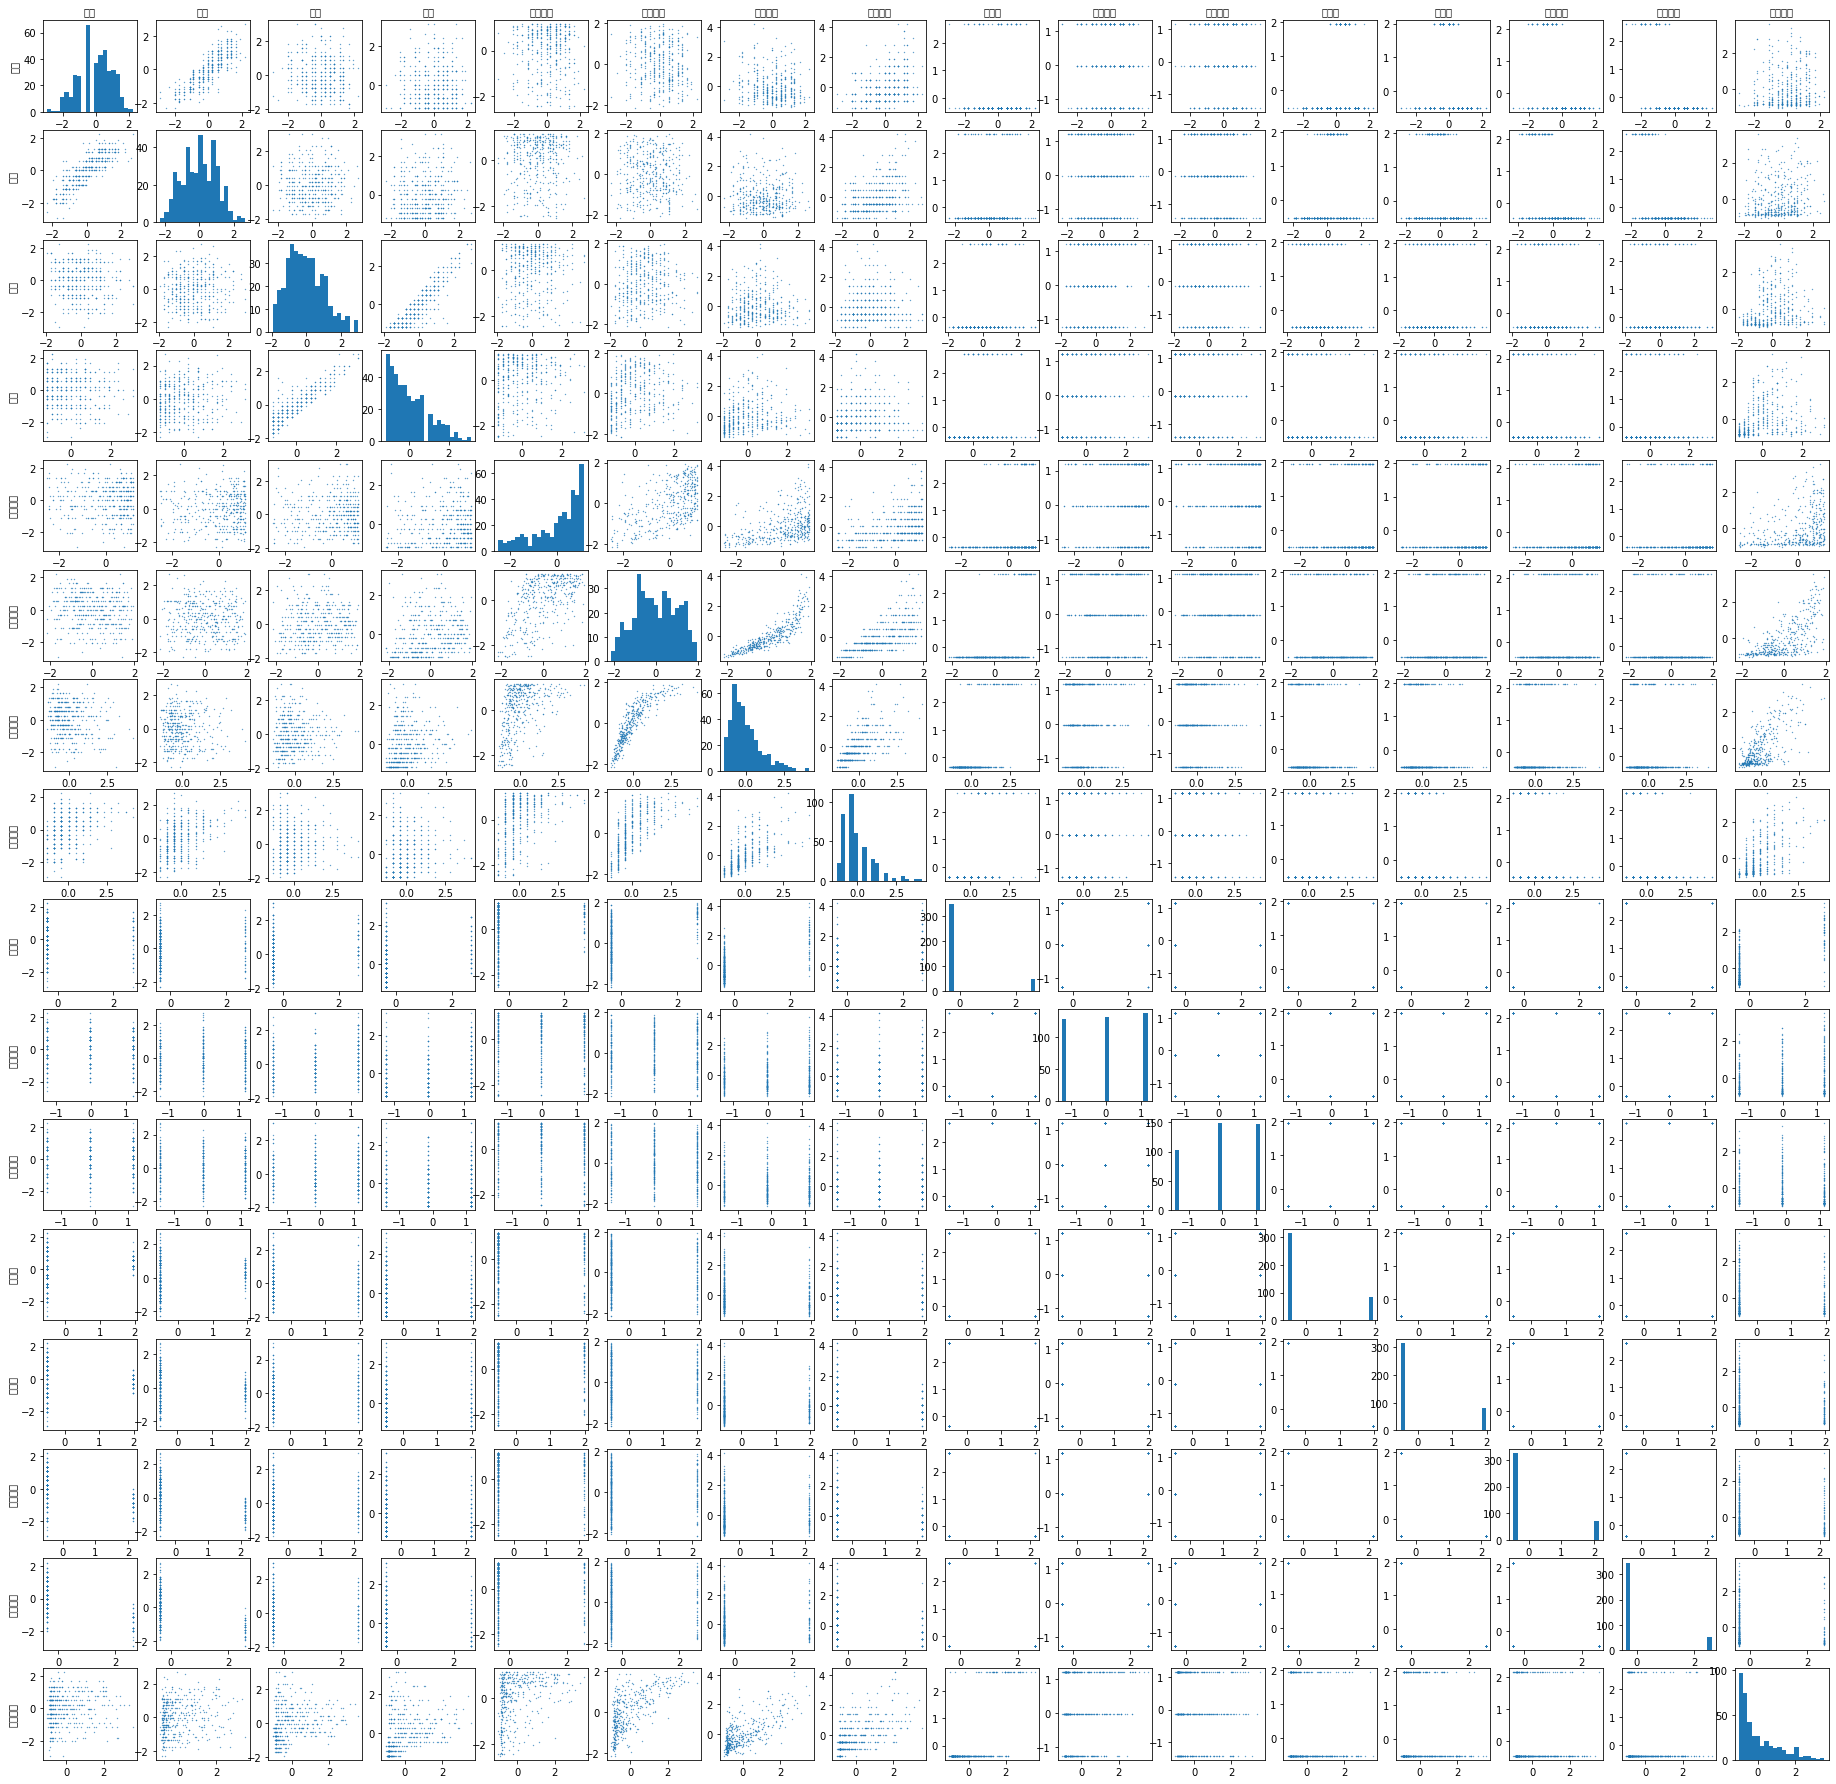

In [47]:
ana.overview()

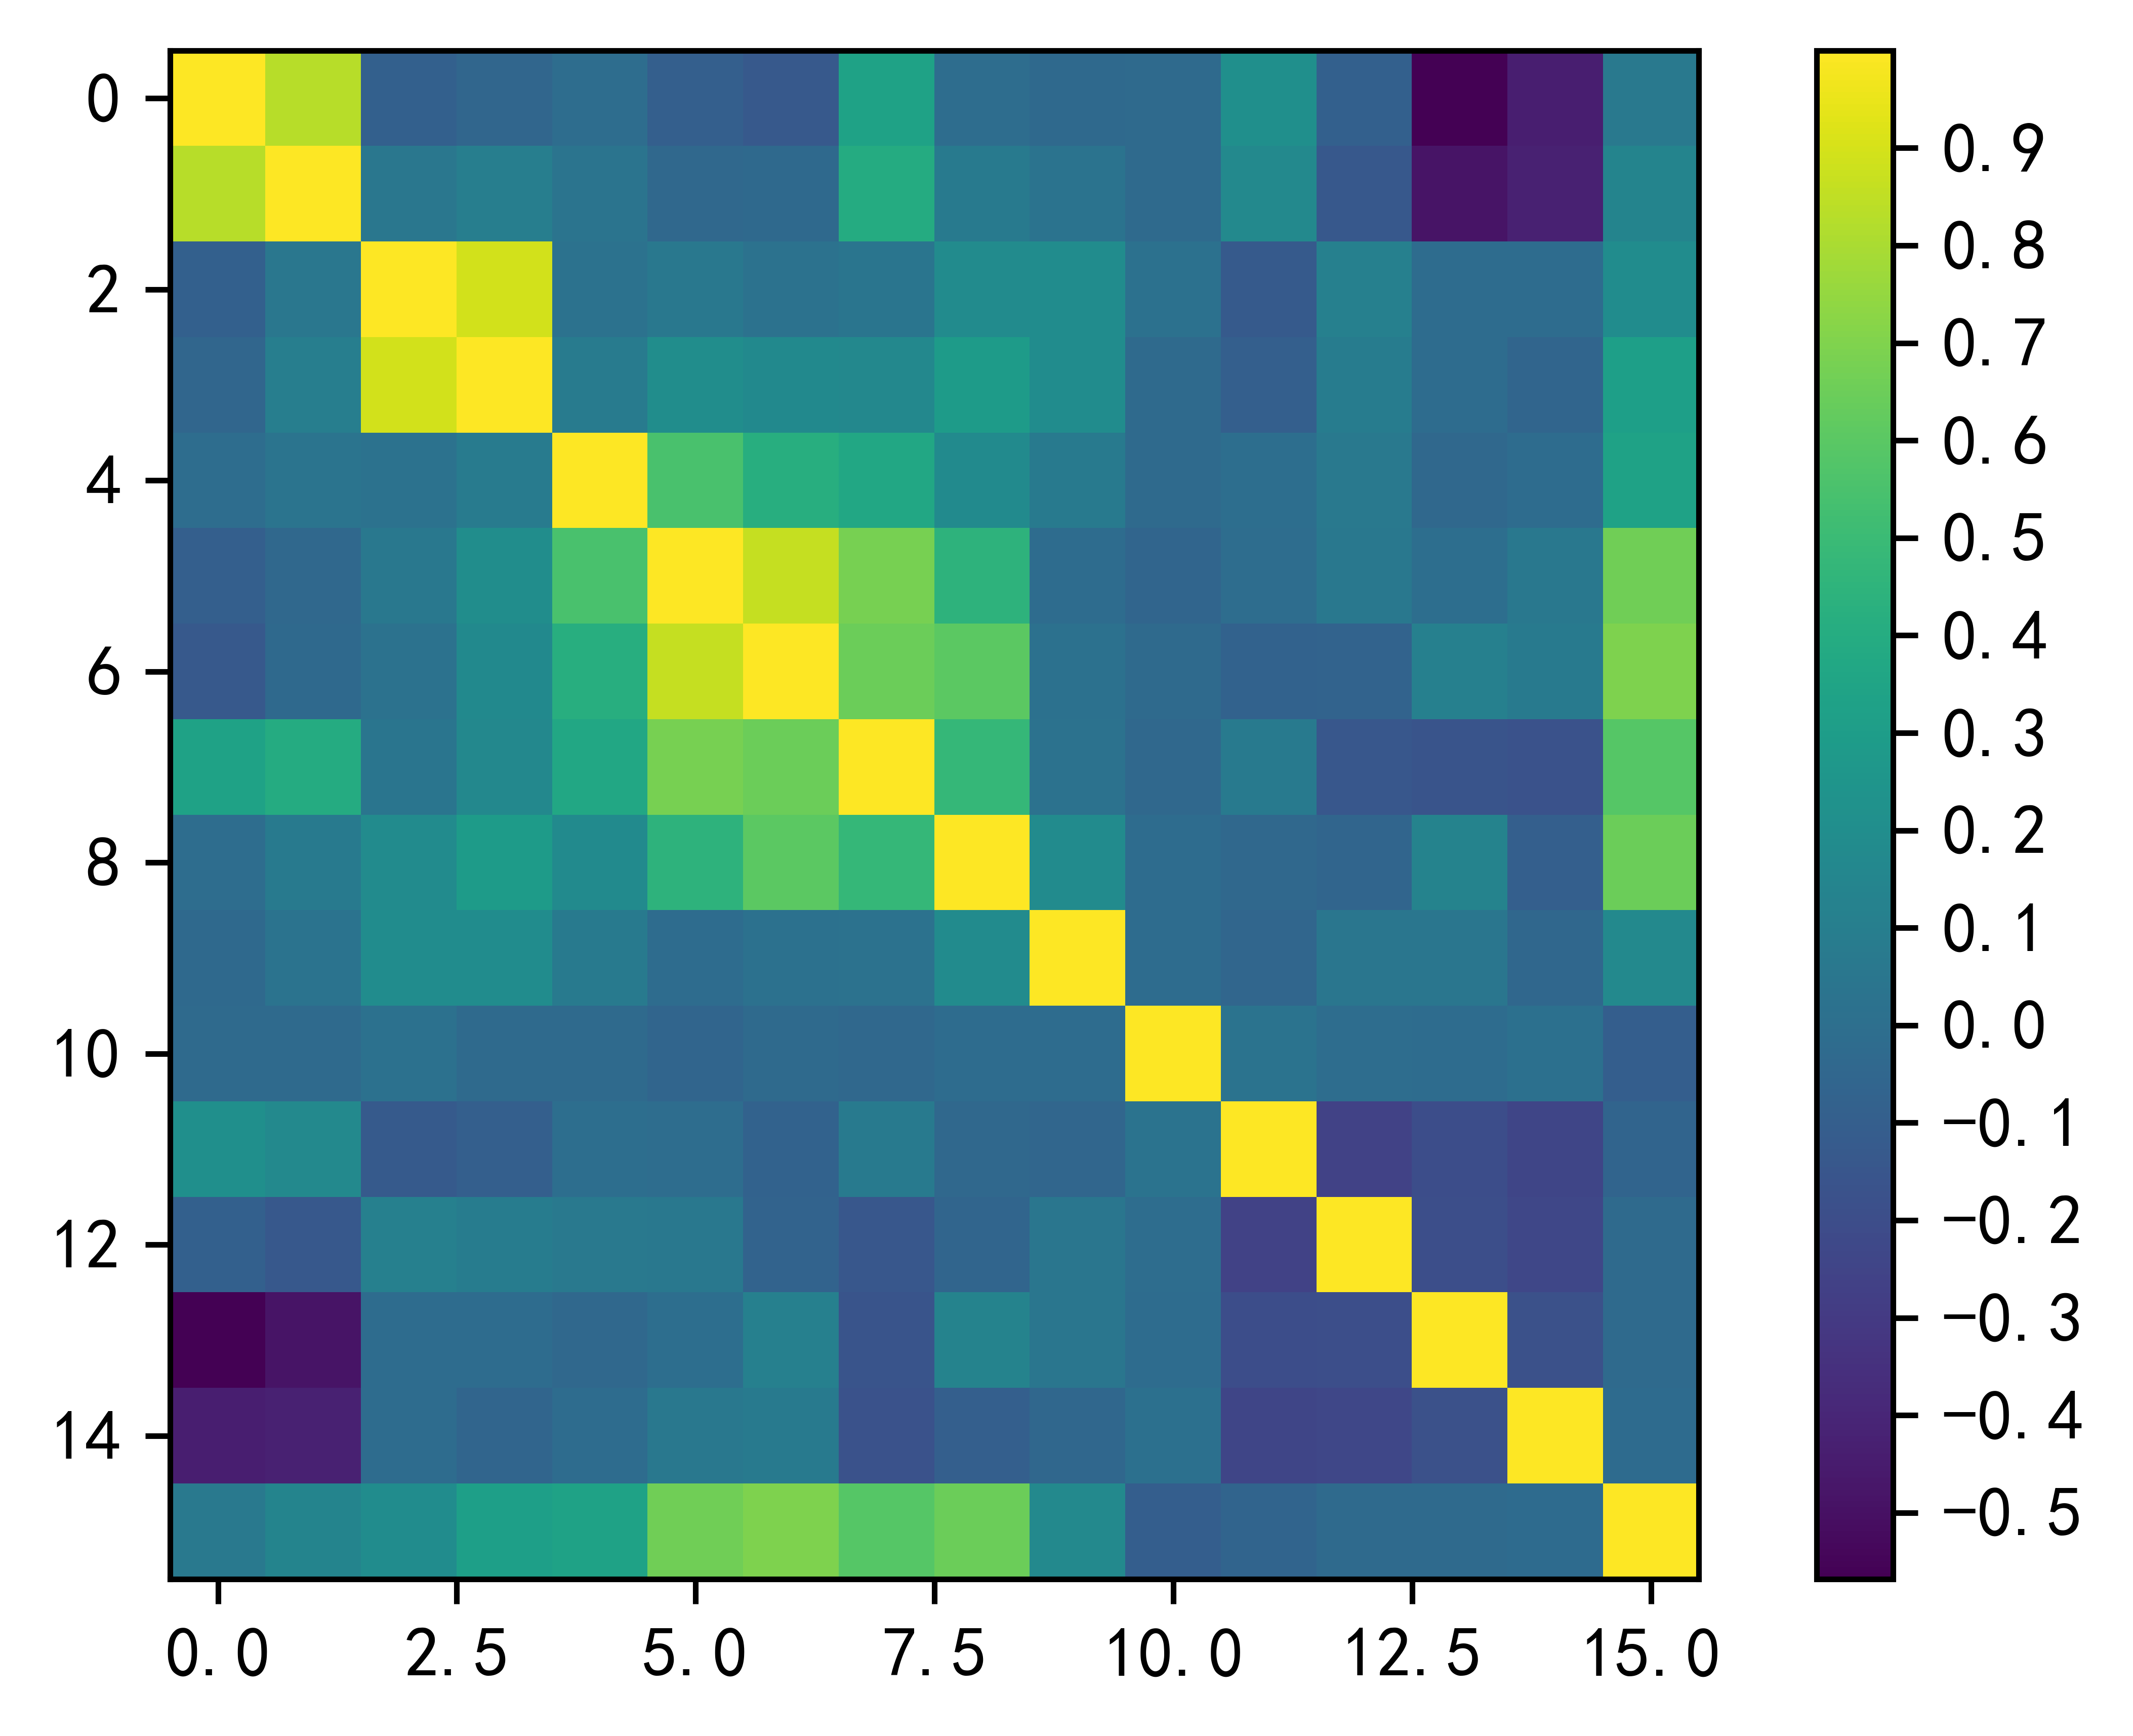

In [611]:
ana.plot_cor()

In [48]:
ana.anova()

             df      sum_sq     mean_sq           F        PR(>F)
身高          1.0    1.882151    1.882151    5.102631  2.445426e-02
体重          1.0    8.865462    8.865462   24.034824  1.402850e-06
年龄          1.0   12.122051   12.122051   32.863642  2.013175e-08
球龄          1.0   33.958419   33.958419   92.063408  1.137906e-19
上场次数        1.0   32.589759   32.589759   88.352886  5.183542e-19
场均时间        1.0  106.204690  106.204690  287.927590  1.675870e-48
进攻能力        1.0   27.196680   27.196680   73.731908  2.314016e-16
防守能力        1.0    1.309601    1.309601    3.550411  6.029179e-02
全明星         1.0   24.779720   24.779720   67.179379  3.816956e-15
球队胜率        1.0    3.200602    3.200602    8.677034  3.420343e-03
球队市值        1.0    1.795339    1.795339    4.867276  2.796681e-02
大前锋         1.0    0.740376    0.740376    2.007205  1.573706e-01
小前锋         1.0    0.256267    0.256267    0.694755  4.050741e-01
得分后卫        1.0    0.452115    0.452115    1.225713  2.689408e-01
控球后卫      

In [49]:
ana.KMO()

KMO值： 0.48563
巴特利特球： 0.0


## linear reg

In [44]:
ana.linear_beta().T

,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,大前锋,小前锋,得分后卫,控球后卫
球员薪金,0.123279,0.001745,0.061414,0.04335,-0.008571,0.307953,0.231822,0.011391,0.328561,0.09361,-0.06639,-0.056633,-0.036077,0.008048,-0.042849


Text(0, 0.5, '球员薪资')

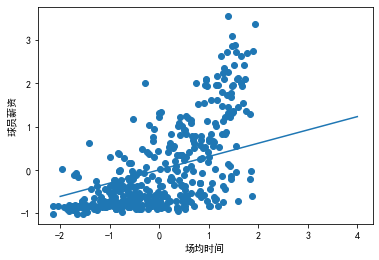

In [50]:
l=np.linspace(-2,4,100)
plt.scatter(ana.X['场均时间'],ana.y)
x=ana.linear_beta().loc['场均时间']
ll=np.linspace(-2*x,4*x,100)
plt.plot(l,ll)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.xlabel('场均时间')
plt.ylabel('球员薪资')

## ridge

E:\anaconda\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'球员薪金_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


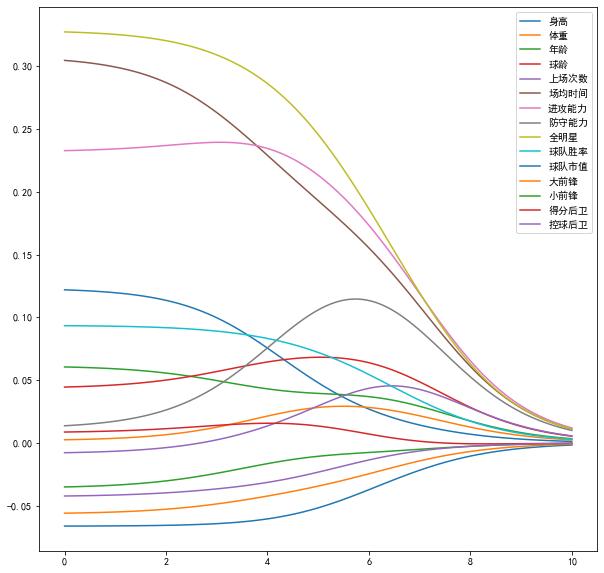

In [51]:
ana.plot_ridge(0,10)

## PCA

In [85]:
ana.PCA(100)

,球员薪金
身高,0.123279
体重,0.001745
年龄,0.061414
球龄,0.043350
上场次数,-0.008571
场均时间,0.307953
进攻能力,0.231822
防守能力,0.011391
全明星,0.328561
球队胜率,0.093610


## evaluate

In [34]:
ridge5=ana.ridge(5)
lin=ana.linear_beta()
print(ana.MSE(ridge5),ana.MSE(lin))

0.36938927865063503 0.3539931675181033


In [43]:
ana.MSE(ana.PCA(1))

0.41274887051312315

In [94]:
ana.MSE(ana.PCA(7))

0.3927062514550247

In [159]:
ana3=analysis(df[['身高','球龄','场均时间','进攻能力','防守能力','全明星','球队胜率','球队市值']],df['球员薪金'])

E:\anaconda\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [160]:
ana3.R2(ana3.linear_beta())

array([[0.64013505]])

In [104]:
data=pd.read_excel('D:\研究生\课程\统计基础\\NBAfinal2.xlsx')
data.head()

,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,球员薪金
0,1.91,86,29,7,79,33.38,31.933,4,1,3,3,3468
1,2.03,113,32,13,74,37.75,36.140,8,1,3,2,3329
2,2.03,112,32,10,69,33.95,22.712,7,1,3,1,3127
3,2.03,103,27,6,73,34.45,25.382,5,1,3,2,2973
4,2.08,114,28,6,61,34.03,27.488,6,1,3,3,2951


In [138]:
ana3=analysis(data.iloc[:,:-1],data.iloc[:,-1])

In [139]:
a=ana3.linear_beta()
b=ana3.

In [140]:
ana3.MSE(a)

array([[0.36907929]])

In [141]:
ana3.R2(a)

array([[0.64117291]])

In [150]:
ana3.R2(ana3.ridge(5))

array([[0.62630446]])

In [158]:
ana3.R2(ana3.PCA(8))

array([[0.63670185]])